#Load Data

In [2]:
import pandas as pd

#TODO: add in extra datasets 
df = pd.read_csv('history.csv')

print(df)

        Symbol                 Date       Open      Close       High  \
0          RPD  2018-01-02 00:00:00  18.660000  19.010000  19.090000   
1          RPD  2018-01-03 00:00:00  19.040001  19.350000  19.650000   
2          RPD  2018-01-04 00:00:00  19.389999  19.980000  20.000000   
3          RPD  2018-01-05 00:00:00  20.000000  20.010000  20.100000   
4          RPD  2018-01-08 00:00:00  20.020000  20.350000  20.500000   
...        ...                  ...        ...        ...        ...   
5177034    RNG  2023-03-14 00:00:00  32.180000  31.590000  32.680000   
5177035    OGI  2023-03-15 00:00:00   0.650000   0.640000   0.651000   
5177036    RNG  2023-03-15 00:00:00  31.320000  32.380001  32.549999   
5177037    OGI  2023-03-16 00:00:00   0.640000   0.649000   0.667000   
5177038    RNG  2023-03-16 00:00:00  32.419998  31.969999  32.580002   

               Low     Volume   AdjClose  
0        18.500000   124200.0  19.010000  
1        19.040001   204100.0  19.350000  
2     

#Generate Features

In [3]:
#Add in special date columns
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df.apply(lambda row: row['Date'].year, axis=1)
df['Month'] = df.apply(lambda row: row['Date'].month, axis=1)
df['DayOfWeek'] = df.apply(lambda row: row['Date'].weekday(), axis=1)
df['WeekOfYear'] = df.apply(lambda row: row['Date'].isocalendar()[1], axis=1)

print(df)

        Symbol       Date       Open      Close       High        Low  \
0          RPD 2018-01-02  18.660000  19.010000  19.090000  18.500000   
1          RPD 2018-01-03  19.040001  19.350000  19.650000  19.040001   
2          RPD 2018-01-04  19.389999  19.980000  20.000000  19.389999   
3          RPD 2018-01-05  20.000000  20.010000  20.100000  19.719999   
4          RPD 2018-01-08  20.020000  20.350000  20.500000  19.950001   
...        ...        ...        ...        ...        ...        ...   
5177034    RNG 2023-03-14  32.180000  31.590000  32.680000  31.230000   
5177035    OGI 2023-03-15   0.650000   0.640000   0.651000   0.629000   
5177036    RNG 2023-03-15  31.320000  32.380001  32.549999  30.990000   
5177037    OGI 2023-03-16   0.640000   0.649000   0.667000   0.629000   
5177038    RNG 2023-03-16  32.419998  31.969999  32.580002  31.180000   

            Volume   AdjClose  Year  Month  DayOfWeek  WeekOfYear  
0         124200.0  19.010000  2018      1          1  

In [4]:
import numpy as np

def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs)

df = generate_cyclical_features(df, 'DayOfWeek', 7, 0)
df = generate_cyclical_features(df, 'Month', 12, 1)
df = generate_cyclical_features(df, 'WeekOfYear', 52, 0)

print(df.columns)

Index(['Symbol', 'Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'AdjClose',
       'Year', 'Month', 'DayOfWeek', 'WeekOfYear', 'sin_DayOfWeek',
       'cos_DayOfWeek', 'sin_Month', 'cos_Month', 'sin_WeekOfYear',
       'cos_WeekOfYear'],
      dtype='object')


In [5]:
import holidays
us_holidays = holidays.US()

def is_holiday(date):
    date = date.replace(hour = 0)
    return 1 if (date in us_holidays) else 0

def add_holiday_col(df, holidays):
    return df.assign(is_holiday = df['Date'].apply(is_holiday))

df = add_holiday_col(df, us_holidays)

print(df.columns)

Index(['Symbol', 'Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'AdjClose',
       'Year', 'Month', 'DayOfWeek', 'WeekOfYear', 'sin_DayOfWeek',
       'cos_DayOfWeek', 'sin_Month', 'cos_Month', 'sin_WeekOfYear',
       'cos_WeekOfYear', 'is_holiday'],
      dtype='object')


In [6]:
#Convert symbol to number
#TODO: This probably is not the best way to convert symbol to a numeric feature
symbol_map = {}
symbol_map_rev = {}

symbols = df['Symbol'].unique()
for i, symbol in enumerate(symbols):
    symbol_map[symbol] = i
    symbol_map_rev[i] = symbol

df['Symbol_Num'] = df.apply(lambda row: symbol_map[row['Symbol']], axis=1)
df = df.drop('Symbol', axis=1)



#Split into Training and Test sets

Do this by breaking data up into date ranges, as we are mirroing a live setup where we have the full 
past data, and need to predict the future. We are not trying to do things like, given random selctions
of dates in the past predict a future date. 

In [7]:
# cols_to_drop = ['Month', 'Date', 'DayOfWeek', 'WeekOfYear']

# train_x = df[(df['Year']==2018) & (df['Month'] < 12)]
# i1 = train_x.set_index(['Symbol_Num']).index
# train_x = train_x.drop(cols_to_drop, axis=1)
# train_y = df[(df['Year']==2018) & (df['Month'] == 12)]
# i2 = train_y.set_index(['Symbol_Num']).index
# train_y = train_y[i2.isin(i1)]
# train_y = train_y.groupby('Symbol_Num').agg({'Volume':["mean"]})

# print(len(train_x), len(train_y))

# val_x = df[(df['Year']==2019) & (df['Month'] < 6)]
# i1 = val_x.set_index(['Symbol_Num']).index
# val_x = val_x.drop(cols_to_drop, axis=1)
# val_y = df[(df['Year']==2019) & (df['Month'] == 6)]
# i2 = val_y.set_index(['Symbol_Num']).index
# val_y = val_y[i2.isin(i1)]
# val_y = val_y.groupby('Symbol_Num').agg({'Volume':["mean"]})

# print(len(val_x), len(val_y))


# test_x = df[(df['Year']==2019) & (df['Month'] < 12) & (df['Month'] > 6)]
# i1 = test_x.set_index(['Symbol_Num']).index
# test_x = test_x.drop(cols_to_drop, axis=1).groupby('Symbol_Num')
# test_y = df[(df['Year']==2019) & (df['Month'] == 12)]
# i2 = test_y.set_index(['Symbol_Num']).index
# test_y = test_y[i2.isin(i1)]
# test_y = test_y.groupby('Symbol_Num').agg({'Volume':["mean"]})

# print(len(test_x), len(test_y))


In [8]:
cols_to_drop = ['Month', 'Date', 'DayOfWeek', 'WeekOfYear']

train_x = df[(df['Year']==2018) & (df['Month'] < 12)].drop(cols_to_drop, axis=1)
train_y = df[(df['Year']==2018) & (df['Month'] == 12)].drop(cols_to_drop, axis=1)

val_x = df[(df['Year']==2019) & (df['Month'] < 6)].drop(cols_to_drop, axis=1)
val_y = df[(df['Year']==2019) & (df['Month'] == 6)].drop(cols_to_drop, axis=1)

test_x = df[(df['Year']==2019) & (df['Month'] < 12) & (df['Month'] > 6)].drop(cols_to_drop, axis=1)
test_y = df[(df['Year']==2019) & (df['Month'] == 12)].drop(cols_to_drop, axis=1)


#Scale the data

In [51]:
from sklearn.preprocessing import StandardScaler
#TODO: Would other types of scalers make a differnce
xscaler = StandardScaler()
yscaler = StandardScaler()
# t = scaler.fit_transform(train_x)
# print(t.shape)
#X_train_arr = transfrom_group(train_x, scaler)
# X_val_arr = transfrom_group(val_x, scaler)
# X_test_arr = transfrom_group(test_x, scaler)


# y_train_arr = scaler.fit_transform(train_y)
# y_val_arr = scaler.transform(val_y)
# y_test_arr = scaler.transform(test_y)

# print(len(X_train_arr), len(y_train_arr))
# print(len(X_val_arr), len(y_val_arr))
# print(len(X_test_arr), len(y_test_arr))

def group(x,y):
    out = {}
    grouped = x.groupby('Symbol_Num')
    yhat = y.groupby('Symbol_Num').agg({'Volume':["mean"]})
    yhat = dict(zip(yhat.index, yhat[('Volume', 'mean')]))
    count = 0
    for symbol, group in grouped:
        if symbol in yhat:
            out[count] = {'x':group, 'y':yhat[symbol]}
            count+=1
    return out

train_grouped = group(train_x, train_y)
val_grouped = group(val_x, val_y)
test_grouped = group(test_x, test_y)

xscaler.fit(train_x)
t = list(train_grouped.values())
y_vals = list(map(lambda x: x['y'], train_grouped.values()))
y_vals = np.array(y_vals)
y_vals = y_vals.reshape(-1, 1)
yscaler.fit(y_vals)

def scale_group(group, xscaler, yscaler):
    out = {}
    for key, item in group.items():
        x = xscaler.transform(item['x'])
        y = yscaler.transform(np.atleast_1d(item['y']).reshape(-1, 1))
        out[key] = {'x':x,'y':y[0][0]}
    return out

train_grouped_scaled = scale_group(train_grouped,xscaler,yscaler)
val_grouped_scaled = scale_group(val_grouped,xscaler,yscaler)
test_grouped_scaled = scale_group(test_grouped,xscaler,yscaler)

print(len(train_grouped_scaled), len(val_grouped_scaled), len(test_grouped_scaled))

#train_x_scaled = pd.DataFrame(scaler.fit_transform(train_x),columns = train_x.columns)
#train_y_scaled = pd.DataFrame(scaler.transform(train_y),columns = train_y.columns)

#val_x_scaled = pd.DataFrame(scaler.fit_transform(val_x),columns = val_x.columns)
#val_y_scaled = pd.DataFrame(scaler.transform(val_y),columns = val_y.columns)

#test_x_scaled = pd.DataFrame(scaler.fit_transform(test_x),columns = test_x.columns)
#test_y_scaled = pd.DataFrame(scaler.transform(test_y),columns = test_y.columns)



3332 3421 3523


#Create Dataloaders

In [10]:
from torch.utils.data import DataLoader, Dataset
import torch
from torch.nn.utils.rnn import pad_sequence
from numpy import argsort

# Create a custom dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        y = y_data.groupby('Symbol_Num').agg({'Volume':["mean"]})
        self.y_data = dict(zip(y.index, y[('Volume', 'mean')]))

        symbols = x_data.groupby('Symbol_Num').groups.keys()
        y_symbols = y_data.groupby('Symbol_Num').groups
        self.symbol_nums = {}
        count = 0
        for key in symbols:
            if key in y_symbols:
                self.symbol_nums[count] = key
                count += 1
        # y = set(y_symbols.keys())
        # x = set(self.symbol_nums.values())
        # print(len(x.intersection(y)))
        # print(-1.7371406599594579 in y)
        self.len = count
        
    def __len__(self):
        return self.len
        
    def __getitem__(self, idx):
        symbol = self.symbol_nums[idx]
        y = self.y_data[symbol]
        x_data = self.x_data[self.x_data["Symbol_Num"]==symbol]
        t = torch.tensor(x_data.values, dtype=torch.float32) #cast to float32 for faster computation
        return t, y, len(x_data)

train_dataset = TimeSeriesDataset(train_x_scaled, train_y_scaled)
val_dataset = TimeSeriesDataset(val_x_scaled, val_y_scaled)
test_dataset = TimeSeriesDataset(test_x_scaled, test_y_scaled)

def time_series_collate(batch):
    #print(len(batch[0]))
    sequence = []
    y_vals = []
    lengths = []
    #pack padded zeros requires inputs to be sorted by length
    sorted_indexes = list(reversed(argsort(list(map(lambda x: x[2], batch)))))
    for i in sorted_indexes:
        sequence.append(batch[i][0])
        y_vals.append(batch[i][1])
        lengths.append(batch[i][2])
    # Pad sequences with zeros to make them the same length
    return pad_sequence(sequence, batch_first=True, padding_value=0), torch.Tensor(y_vals), torch.Tensor(lengths)

#TODO: Is there a better approach here than just dropping the last batch
#TODO: Weights and Balances - optimize batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=time_series_collate, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=time_series_collate, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=time_series_collate, drop_last=True)
test_loader_one = DataLoader(test_dataset, batch_size=1, drop_last=True)



In [11]:
#print(len(train_dataset))
#train_dataset[0]

for x in train_loader:
    print(x)
    break


(tensor([[[-0.0216, -0.0220, -0.0208,  ...,  1.6189, -0.0944, -1.7038],
         [-0.0216, -0.0220, -0.0208,  ...,  1.6189, -0.0944, -1.7038],
         [-0.0216, -0.0220, -0.0208,  ...,  1.6189, -0.0944, -1.7038],
         ...,
         [-0.0216, -0.0220, -0.0208,  ...,  1.4588, -0.0944, -1.7038],
         [-0.0216, -0.0220, -0.0208,  ...,  1.4588, -0.0944, -1.7038],
         [-0.0216, -0.0219, -0.0207,  ...,  1.4588, -0.0944, -1.7038]],

        [[-0.0152, -0.0152, -0.0148,  ...,  1.6189, -0.0944, -1.7218],
         [-0.0151, -0.0154, -0.0148,  ...,  1.6189, -0.0944, -1.7218],
         [-0.0151, -0.0153, -0.0149,  ...,  1.6189, -0.0944, -1.7218],
         ...,
         [-0.0166, -0.0168, -0.0162,  ...,  1.4588, -0.0944, -1.7218],
         [-0.0166, -0.0167, -0.0160,  ...,  1.4588, -0.0944, -1.7218],
         [-0.0165, -0.0167, -0.0161,  ...,  1.4588, -0.0944, -1.7218]],

        [[-0.0184, -0.0186, -0.0176,  ...,  1.6189, -0.0944, -1.7086],
         [-0.0183, -0.0187, -0.0178,  ...,  

# Define model

In [12]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        #unpad 
        x = pack_padded_sequence(x, lengths, batch_first=True)
        
        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        #pad back to expected length
        out, lengths = pad_packed_sequence(out, batch_first=True)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [13]:
from datetime import datetime
import matplotlib.pyplot as plt

class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y, lengths):
        # Sets model to train mode
        self.model.train()

        #print(x.shape)

        # Makes predictions
        yhat = self.model(x, lengths)

        #print(y.shape, yhat.shape)
        #print(y)
        #print(y, yhat)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        model_path = f'models/gru_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            count = 0
            for x_batch, y_batch, lengths in train_loader:
                #TODO: What does this view do here?
                #print("DIMS: ", x_batch.shape)
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.view([batch_size,-1]).to(device)
                loss = self.train_step(x_batch, y_batch, lengths)
                batch_losses.append(loss)
                count += 1
                if not count % 15:
                    print("Epoch {}, Batch Num: {}, Loss: {}".format(epoch, count, loss))

            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val, lengths in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.view([batch_size,-1]).view([batch_size,-1]).to(device)
                    self.model.eval()
                    yhat = self.model(x_val, lengths)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            print(
                f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
            )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test, lengths in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.view([batch_size,-1]).to(device)
                self.model.eval()
                yhat = self.model(x_test, lengths)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values
    
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [14]:

def get_model(model, model_params):
    models = {
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

In [15]:
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

#TODO: get this working on GPU
# Set the device
#device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"
device = torch.device(device)
print(f"Using device: {device}")

Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: cpu


Epoch 1, Batch Num: 15, Loss: 0.030896976590156555
Epoch 1, Batch Num: 30, Loss: 0.03908456489443779
Epoch 1, Batch Num: 45, Loss: 0.024201523512601852
[1/15] Training loss: 0.7627	 Validation loss: 1.3091
Epoch 2, Batch Num: 15, Loss: 0.11441574990749359
Epoch 2, Batch Num: 30, Loss: 0.035680968314409256
Epoch 2, Batch Num: 45, Loss: 0.0389910563826561
[2/15] Training loss: 0.5581	 Validation loss: 0.5713
Epoch 3, Batch Num: 15, Loss: 0.1641879677772522
Epoch 3, Batch Num: 30, Loss: 0.047281425446271896
Epoch 3, Batch Num: 45, Loss: 0.04727094620466232
[3/15] Training loss: 0.4410	 Validation loss: 0.7522
Epoch 4, Batch Num: 15, Loss: 0.12468023598194122
Epoch 4, Batch Num: 30, Loss: 0.029003383591771126
Epoch 4, Batch Num: 45, Loss: 0.028319213539361954
[4/15] Training loss: 0.3655	 Validation loss: 0.5774
Epoch 5, Batch Num: 15, Loss: 0.07668980211019516
Epoch 5, Batch Num: 30, Loss: 0.07125762850046158
Epoch 5, Batch Num: 45, Loss: 0.024183008819818497
[5/15] Training loss: 0.3341	

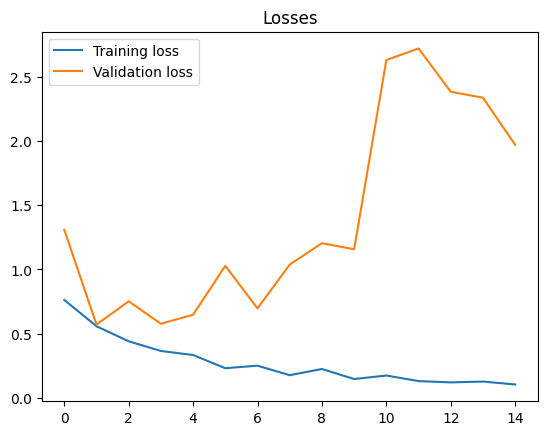

In [16]:
import torch.optim as optim

#TODO: Optimize these paramaters - Weights and Balances
input_dim = len(train_x.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 15
learning_rate = 3e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

#TODO: Try other Models  - Weights and Balances
model = get_model('gru', model_params).to(device)

#TODO: Try other loss functions and optimizers - Weights and Balances
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#TODO: Optimize training performance
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

#TODO: Plot actual predictions vs averages to see how we did


# Plot Predictions

In [21]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    print(df_test.columns)
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, test_x, scaler)

Index(['Open', 'Close', 'High', 'Low', 'Volume', 'AdjClose', 'Year',
       'sin_DayOfWeek', 'cos_DayOfWeek', 'sin_Month', 'cos_Month',
       'sin_WeekOfYear', 'cos_WeekOfYear', 'is_holiday', 'Symbol_Num'],
      dtype='object')


ValueError: operands could not be broadcast together with shapes (3523,2) (15,) (3523,2) 